In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [1]:
from src.py_scripts.process_pals import begin_processing

In [40]:
random_seed = 17

# Data preparation

In [ ]:
# True positive data
PATH = 'some_strange_data/S10-20_L0-8_M5'
TARGET = '1'
LINES = 'last'
OMIT = ''
OUTPUT_FILE = 'sl_annotation_result.csv'
N_LINES = 0

In [ ]:
begin_processing(
    PATH,
    TARGET,
    LINES,
    OMIT,
    output_file=OUTPUT_FILE,
    n_lines=N_LINES,
)

In [ ]:
# True negative data
PATH = 'some_another_strange_data/S10-20_L0-8_M5'
TARGET = '1'
LINES = 'first'
OMIT = ''
OUTPUT_FILE = 'sl_annotation_result.csv'
N_LINES = 0

In [ ]:
begin_processing(
    PATH,
    TARGET,
    LINES,
    OMIT,
    output_file=OUTPUT_FILE,
    n_lines=N_LINES,
)

# Data analysis & visualisation

In [26]:
df = pd.read_csv(OUTPUT_FILE, index_col=0)
X = df.drop("is_target", axis=1)
Y = df["is_target"]

In [ ]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=2000)
folded_data = KFold(n_splits=5, random_state=random_seed)

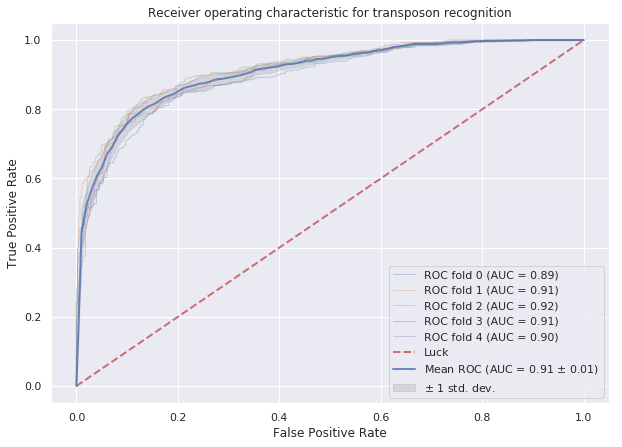

In [34]:
tprs = []
aucs, acc, rec, prec = [], [], [], []

mean_fpr = np.linspace(0, 1, 100)
i = 0

plt.figure(figsize=(10,7))
for k, (train, test) in enumerate(folded_data.split(X, Y)):
    probas_ = rf.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    Y_pred = rf.predict(X.iloc[test])
    acc.append(accuracy_score(Y.iloc[test], Y_pred))
    prec.append(precision_score(Y.iloc[test], Y_pred))
    rec.append(recall_score(Y.iloc[test], Y_pred))
    plt.plot(
        fpr,
        tpr,
        lw=1,
        alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc)
    )

plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    lw=2,
    color='r',
    label='Luck',
    alpha=.8
)
fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color='grey',
    alpha=.2,
    label=r'$\pm$ 1 std. dev.'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for transposon recognition')
plt.legend(loc="lower right")
plt.show()

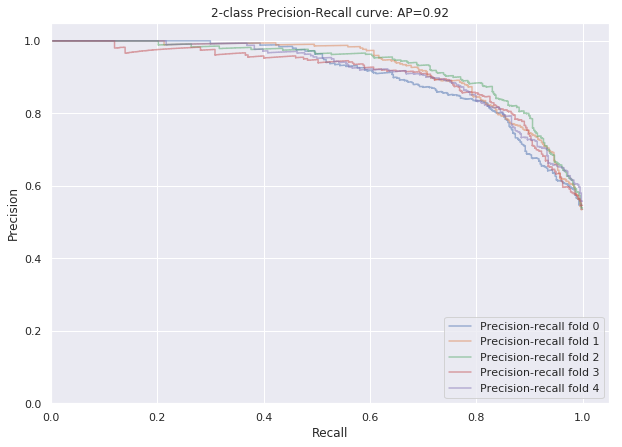

In [33]:
precisions = []
plt.figure(figsize=(10,7))
for k, (train, test) in enumerate(folded_data.split(X, Y)):
    probas_ = rf.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
    precision, recall, _ = precision_recall_curve(Y.iloc[test], probas_[:, 1])
    precisions.append(average_precision_score(Y.iloc[test], probas_[:, 1]))
    plt.step(
        recall,
        precision,
        alpha=0.5,
        where='post',
        label='Precision-recall fold {}'.format(k)
    )
average_precision = sum(precisions)/len(precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.legend(loc="lower right")
plt.show()

# AUC, Accuracy, Precision & Recall

In [36]:
mr = lambda x: np.round(np.mean(x), 4)
mr(aucs), mr(acc), mr(prec), mr(rec)

(0.9077, 0.8334, 0.8377, 0.8238)

# Feature importance

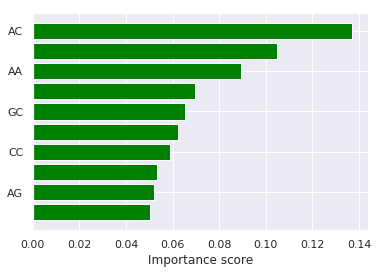

In [37]:
N_to_print = 10
fig, ax = plt.subplots()
plt.figure(figsize=(10,7))

feature_importance = rf.feature_importances_.round(4)
feature_importance = zip(X.keys(), feature_importance)
feature_importance = np.array(sorted(feature_importance, key=lambda x:x[1], reverse=True))

ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
ax.set_yticks(np.arange(N_to_print), N_to_print)
ax.set_yticklabels(feature_importance[:N_to_print, 0])
ax.invert_yaxis()
ax.set_xlabel('Importance score')
ax.title("Feature importance")

plt.show()

In [38]:
feature_importance = (rf.feature_importances_).round(4)
feature_importance = zip(X.keys(), feature_importance)
feature_importance = sorted(list(feature_importance), key=lambda x:x[1], reverse=True)
pd.DataFrame(feature_importance, columns=['Feature_name', 'Feature_importance']).head(N_to_print)

,Feature_name,Feature_importance
0,TT,0.1369
1,AC,0.1048
2,AA,0.0893
3,GC,0.0695
4,CC,0.0655
5,AG,0.0622
6,CA,0.0590
7,AT,0.0532
8,TA,0.0521
9,GG,0.0503
